In [83]:
import torch
from torch import nn
import matplotlib.pyplot as plt

In [84]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


In [87]:
weight = 0.3
bias = 0.9

start = 0
end = 1
step = 0.01
# create 100 evenly spaced points between start and end
X = torch.arange(start, end, step).unsqueeze(dim=1).to(device)
y = weight * X + bias

In [88]:
X.shape, X[:10]

(torch.Size([100, 1]),
 tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400],
         [0.0500],
         [0.0600],
         [0.0700],
         [0.0800],
         [0.0900]], device='mps:0'))

In [89]:
# check on which device is variable y
y.device

device(type='mps', index=0)

In [90]:
# Create train, test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([80, 1]),
 torch.Size([80, 1]),
 torch.Size([20, 1]),
 torch.Size([20, 1]))

In [91]:
def plot_predictions(train_data = X_train.cpu(), train_labels = y_train.cpu(),
                     test_data = X_test.cpu(), test_labels = y_test.cpu(),
                     predictions = None):
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training Data")
    plt.scatter(test_data, test_labels, c="g", s=4, label = "Test data")
    if predictions is not None:
        plt.scatter(test_data, predictions.cpu(), c="r", s=4, label = "Predictions")
    plt.legend()

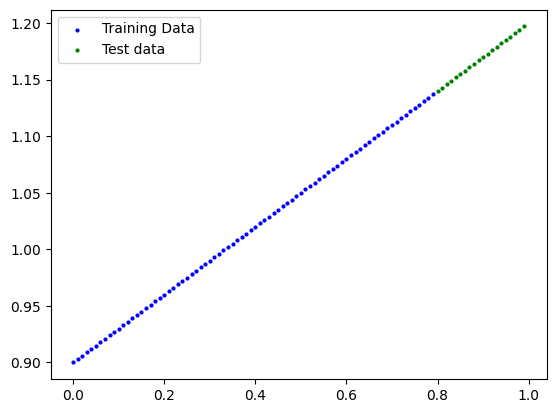

In [92]:
plot_predictions()

In [93]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, dtype = torch.float),
                                    requires_grad=True)
        self.bias = nn.Parameter(torch.randn(1, dtype = torch.float),
                                 requires_grad=True)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias

In [94]:
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer = nn.Linear(in_features=1, out_features=1)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

In [95]:
torch.manual_seed(42)

model_0 = LinearRegressionModel()
model_1 = LinearRegressionModelV2()

model_0.to(device)
model_1.to(device)

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [96]:
next(model_1.parameters()).device, X_train.device

(device(type='mps', index=0), device(type='mps', index=0))

In [97]:
model_0.state_dict(), model_1.state_dict()

(OrderedDict([('weights', tensor([0.3367], device='mps:0')),
              ('bias', tensor([0.1288], device='mps:0'))]),
 OrderedDict([('linear_layer.weight', tensor([[-0.2191]], device='mps:0')),
              ('linear_layer.bias', tensor([0.2018], device='mps:0'))]))

In [98]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_0.parameters(), lr = 0.01)

In [99]:
torch.manual_seed(42)
epochs = 1000

train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    model_0.train()
    y_preds = model_0(X_train)
    loss = loss_fn(y_preds, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_0.eval()
    with torch.inference_mode():
        test_preds = model_0(X_test)
        test_loss = loss_fn(test_preds, y_test)
        if epoch%20 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().cpu().numpy())
            test_loss_values.append(test_loss.detach().cpu().numpy())

            print(f"Epoch: {epoch} | Train Loss: {loss.item()} | Test Loss: {test_loss.item()}")



Epoch: 0 | Train Loss: 0.7566978931427002 | Test Loss: 0.7248174548149109
Epoch: 20 | Train Loss: 0.5254929065704346 | Test Loss: 0.4541124403476715
Epoch: 40 | Train Loss: 0.2942880392074585 | Test Loss: 0.18340764939785004
Epoch: 60 | Train Loss: 0.07658576965332031 | Test Loss: 0.07274086028337479
Epoch: 80 | Train Loss: 0.05255373939871788 | Test Loss: 0.11581540107727051
Epoch: 100 | Train Loss: 0.04554273188114166 | Test Loss: 0.10467890650033951
Epoch: 120 | Train Loss: 0.038688670843839645 | Test Loss: 0.08938358724117279
Epoch: 140 | Train Loss: 0.03183453530073166 | Test Loss: 0.07408786565065384
Epoch: 160 | Train Loss: 0.024982361122965813 | Test Loss: 0.0581042543053627
Epoch: 180 | Train Loss: 0.018130186945199966 | Test Loss: 0.04212063178420067
Epoch: 200 | Train Loss: 0.011278990656137466 | Test Loss: 0.02579306997358799
Epoch: 220 | Train Loss: 0.004429381340742111 | Test Loss: 0.009467745199799538
Epoch: 240 | Train Loss: 0.00370177929289639 | Test Loss: 0.0064894440

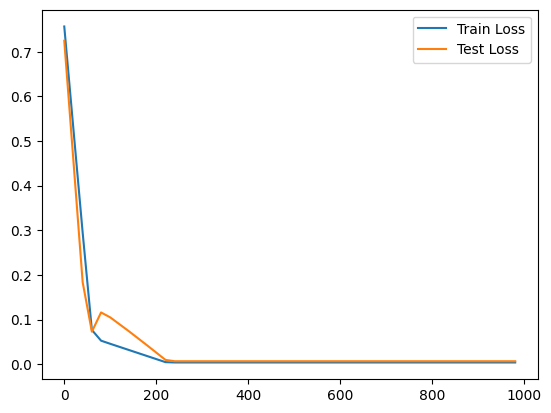

In [100]:
plt.plot(epoch_count, train_loss_values, label = "Train Loss")
plt.plot(epoch_count, test_loss_values, label = "Test Loss")
plt.legend()

In [101]:
model_0.eval()
with torch.inference_mode():
    test_predictions = model_0(X_test)
test_predictions[:10]

tensor([[1.1464],
        [1.1495],
        [1.1525],
        [1.1556],
        [1.1587],
        [1.1617],
        [1.1648],
        [1.1679],
        [1.1709],
        [1.1740]], device='mps:0')

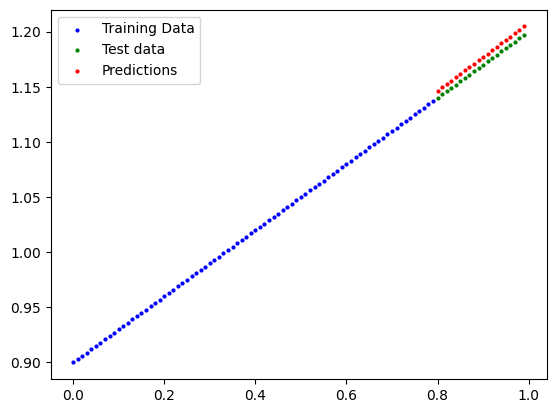

In [102]:
plot_predictions(predictions=test_predictions)

In [103]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3067], device='mps:0')),
             ('bias', tensor([0.9011], device='mps:0'))])

In [104]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents = True, exist_ok = True)

MODEL_NAME = "01_PyTorchWorkFlow_exercise.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving them model to: {MODEL_SAVE_PATH}")
torch.save(model_0.state_dict(), MODEL_SAVE_PATH)

Saving them model to: models/01_PyTorchWorkFlow_exercise.pth


In [105]:
loaded_model_0 = LinearRegressionModel()
loaded_model_0.load_state_dict(torch.load(MODEL_SAVE_PATH))

loaded_model_0.to(device)

/var/folders/sz/gk2spb8j48nd7k74nz3bmv8w0000gn/T/ipykernel_59629/2429953394.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_0.load_state_dict(torch.load(MOD

LinearRegressionModel()

In [106]:
loaded_model_0.eval()
with torch.inference_mode():
    loaded_model_0_predictions = loaded_model_0(X_test)
test_predictions == loaded_model_0_predictions

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='mps:0')